In [1]:
import matplotlib
# matplotlib.use('TkAgg')

import pylab
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import signal, interpolate

# importation de module pour la manipulation de fichiers audios
from fastdtw import fastdtw, dtw
from pydub import AudioSegment
from scipy.io.wavfile import read as wread
from scipy.spatial.distance import euclidean

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


C:\ProgramData\Anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
tDicoSonsConnus = {}
nLongueurMinSonConnu = np.Inf
bDurees = False
#hamming
nTailleFen = round(22050*0.01) #10 ms

In [3]:
def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise ValueError( 
                "Input vectors y_axis and x_axis must have same length")
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis


def peakdetect(y_axis, x_axis = None, lookahead = 200, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    
    function for detecting local maxima and minima in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maxima and minima respectively
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the position of the peaks. If omitted an
        index of the y_axis is used.
        (default: None)
    
    lookahead -- distance to look ahead from a peak candidate to determine if
        it is the actual peak
        (default: 200) 
        '(samples / period) / f' where '4 >= f >= 1.25' might be a good value
    
    delta -- this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            When omitted delta function causes a 20% decrease in speed.
            When used Correctly it can double the speed of the function
    
    
    return: two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tuple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError("Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
#     try:
#         if dump[0]:
#             max_peaks.pop(0)
#         else:
#             min_peaks.pop(0)
#         del dump
#     except IndexError:
#         #no peaks were found, should the function return empty lists?
#         pass
        
    return [max_peaks, min_peaks]

In [4]:



# def w_k(k, n, N):
#     return np.exp(2*1j*k*n*np.pi/N)

# def dft(s, N):
#     result = [0]*int(N)
#     k = 0
#     while (k<N):
#         n=0
#         while (n<N):
#             result[k] += s[n]*w_k(k,n,N).conjugate()
#             n = n + 1
#         k = k + 1
#     return result


# # Fichier en entrée (ce qui a été dit)

# f_echant, data = wread('sound/1.wav')
# facteur = 16

# # representation amplitude fréquence
# abscisse = []
# ordonne = []
# cpt = 0


    
# Protocole à suivre :
#     récupération du signal
#     découpage en trames/fenetres de hamming
#     application de la fft sur chaque trame pour avoir le spectre
#     récupération des paramètres/caractéristiques du spectre par la mfcc
#     on obtient alors le cepstre
#     application du liftrage pour enlever le bruit/récupérer que ce qui nous intéresse
    
#     Comparaison ici des résultats avec dft appliquée sur de petites fenêtres au cas où le signal est distordu ?
    
#     Optimisation par détection des silences pour ne pas en prendre compte ?


# np.fft()
# np.dft()
# np.dft_signal_ss_echant()



# normalement on applique la DFT sur tout le signal donc avec N=len(s)
# cependant avec cette méthode de calcul non optimisée, c'est trop lent
# il faut sous-echantilloner, par exemple d'un facteur 4

# print ("Nombre d'echantillons du signal sous-echantillone d'un facteur ", facteur, " : ", len(data)/facteur)
# taille de la transformée de Fourier
# N = int(len(data) / facteur)  # on prend une valeur paire pour N
# if (N%2!=0):
#     N = N -1
# print ("Taille de la DFT : ",N)
# Nouvelle fréquence d'échantillonage
# NFS = f_echant / facteur
# print ("Nouvelle Frequence d'echantillonage : ", NFS )
# nouvelle resolution fréquentielle
# = une des valeurs de la DFT représente (englobe) combien de Hz
# RF = NFS / N
# print ("Resolution frequentielle: ", RF)

# on calcul la DFT du signal sous-echantillone
# dft_signal_ss_echant=dft(data[::facteur],len(data)//facteur)

# on affiche le spectre d'amplitude, que sur la moitié à cause de la symétrie fréquentielle
# on passe les amplitudes en dB
# cpt = 0
# abscisse = []
# ordonne = []
# while (cpt<N):
#         abscisse.append(RF * cpt)
#         ordonne.append(10 * np.log10(abs(dft_signal_ss_echant[cpt])))
        # cpt += 1


def hammi(signal):
    # découpage en fenetres de hamming, 22050 fps, pour 20ms la fenetre ça fait 22050*0.020
    global nTailleFen
#     nTailleFen = round(22050*0.01) #10 ms
    fenPure = np.hamming(nTailleFen)
    nSize = len(signal)
    tSortie = []
#     print(fenPure[:50])
#     print( signal)
#     print(nSize)
#     print(nTailleFen)
#     print(nSize//nTailleFen)
#     n = 20
#     tSortie.append( signal[n*nTailleFen:(n+1)*nTailleFen]*fenPure )
#     print( tSortie)
    n=0
    nDecal = (nTailleFen+1)//2
#     nDecal = nTailleFen
    while (n*nDecal) < (nSize-nTailleFen):
#     for n in range (nSize):
        tSortie.append( signal[n*nDecal:n*nDecal +nTailleFen]*fenPure )
        n +=1
    
    #padding de 0 en sortie, 5? fois la longueur initiale, pour plus de précision sur la fft/dft
#     for _ in range()
    
    return tSortie
    
    
def Affichages(sFichier, data, dataModded, tZRC, tZREnergie, tSignalHamminged, tSignalFft, tSilences=[], \
               bSignalOrignal = True, bHamminged=True, bZRs=True, bFftFused=True, bFFTs=True, bPeaks=True):
    # print(tZRC3[::100])
    %matplotlib inline
    if (bSignalOrignal):
        plt.plot(data)
    if (len(tSilences)>0):
        plt.plot(tSilences, [2000 for _ in range(len(tSilences))], "o")
    if (bZRs):
        # plus la fenetre est courte et plus la courbre est agitée
        plt.plot(tZRC)
        plt.plot(tZREnergie)
    if (bSignalOrignal or bZRs):
        plt.title("Fichier "+str(sFichier))
        plt.show()
    
    if (bHamminged):
        nDecalage = (len(tSignalHamminged[0])+1)//2
        # [x * 221 for x in  list(range(0,len(tSignalHamminged)) ) ]
        # plt.plot([item for sublist in tSignalHamminged for item in sublist] )
        plt.plot([x * nDecalage for x in  list(range(0,len(tSignalHamminged)) ) ], tSignalHamminged)
        plt.title("fenêtré hamming")
        plt.show()

    if (bFftFused): #merged
        plt.plot([x * nDecalage for x in  list(range(0,len(tSignalFft)) ) ], tSignalFft)
        # plt.plot([item for sublist in tSignalFft for item in sublist] )
        plt.title("fft")
        plt.show()

    if (bFFTs):
        # plot sur chaque fft, fréquence en abscices db sans log sur ordonnée
        nLongueurMaxFFT = len(tSignalFft[0])
        nLongOpti = nLongueurMaxFFT//2
#         for x in range (len(tSignalFft)):
#             nLongueurMaxFFT = max(nLongueurMaxFFT, len(tSignalFft[x]) )
        
        for x in range (len(tSignalFft)):
            plt.plot(tSignalFft[x][:nLongOpti])
            plt.title("Fenêtre : "+ str(x))
            #ligne = signal.find_peaks_cwt(tSignalFft[x],np.arange(1,6),max_distances=[50,50,50,50,50], noise_perc=5, gap_thresh=25 )
            
            #findpeaks()
#             vals = []
            #print(ligne)
#             for xi in range(len(ligne)):
#                 vals.append( tSignalFft[x][ligne[xi]] )
#             print(vals)
#             plt.plot(ligne, vals )
            if (bPeaks):
                nDelta = max(tSignalFft[x]) *0.5 # *0.3
                ligne = peakdetect(tSignalFft[x][:nLongOpti], lookahead=6, delta=nDelta)
                plt.plot([ item[0] for item in ligne[0]], [ item[1] for item in ligne[0]], "o")
            plt.show()

def detectPics(tSignalFft) :
    tSuccessionPics = []
    nLongueurMaxFFT = len(tSignalFft[0])
    nLongOpti = nLongueurMaxFFT//2
    for x in range (len(tSignalFft)):
        nDelta = max(tSignalFft[x]) *0.5 #*0.3
        ligne = peakdetect(tSignalFft[x][:nLongOpti], lookahead=6, delta=nDelta) #delta 800
        #ligne 0 a les pics positifs, ligne[1] les négatifs. tSignalFFT a les modules des complexes donc absolu, que des positifs sur ligne
        #ligne = tSignalFft[x]
        #item1 pour la puissance du pic, mais on veut l'abscisse, la fréquence donc item0
        [tSuccessionPics.append(item[0]) for item in ligne[0]]
#     print (tSuccessionPics)
    return tSuccessionPics
         
    

def HammingPaddingFourier(dataModded):
    tSignalHamminged = hammi(dataModded)
    # print(tSignalHamminged)
    tSignalFft = tSignalHamminged[:]
    
    #padding de 0 en sortie, 5? fois la longueur initiale, pour plus de précision sur la fft/dft
    tPaddTableau = np.array([0] * len(tSignalFft[0]) *5)
    # print(tSignalFft[10])
    for x in range(len(tSignalFft)):
        tSignalFft[x] = np.concatenate((tSignalFft[x],tPaddTableau))
    # print(tSignalFft[10])    

    tSignalFft = list(map(np.fft.fft, tSignalFft) )
    Reel = lambda x: x.real
    Image = lambda x: x.imag
    Module = lambda x: abs(x)
    tSignalFft = list(map(Module, tSignalFft) )
    return (tSignalHamminged, tSignalFft)
    
def detectVoix(data, nSeuil=30, bExcluSilences = False): #vad voice active detection
    dataModded = data[:]
    if (bDurees):
        nTps = time.process_time()
    tSignalHamminged = hammi(data)
    if (bDurees):
        print("Durée Hamming: ", time.process_time()-nTps )
        nTps = time.process_time()
    #ZRC zero crossing rate, pour elimination des silences
    tnbZeros = [1]*len(data)
    cpt = 1
    while cpt<len(data):
        if (data[cpt]>0 and data[cpt-1]>0):
#             tnbZeros.append(0)
            tnbZeros[cpt] = 0
        elif (data[cpt]<0 and data[cpt-1]<0):
#             tnbZeros.append(0)
            tnbZeros[cpt] = 0
#         else:
#             tnbZeros.append(1)
        cpt +=1

    cpt = 0
    nNbSignauxHam = len(tSignalHamminged)
    tZRC2 = [0]*len(data)
    tZRC3 = [0]*len(data)
    tEnergie = [0]*nNbSignauxHam
#     tSignalHamminged
    
    nHam = len(tSignalHamminged[0])
    nDecalage = (nHam+1)//2
    
    cpt=0
    for indice, item in enumerate(tSignalHamminged):
        nMoyEnergie = 0
        #Entre officiel et alternative différence de temps alt:0.062, offi:0.109
        #officiel, somme de carrés moyennés
        for x in range(nHam):
            nMoyEnergie += (data[x+indice*nDecalage]/nHam)**2
        #alternative tentée pour réduction de coûts
#         for x in range(nHam):
#             nMoyEnergie += data[x+indice*nDecalage]
#         nMoyEnergie = (nMoyEnergie/nHam)**2
        
#         tEnergie.append(nMoyEnergie)
        tEnergie[cpt] = nMoyEnergie
        cpt +=1
    
    if (bDurees):
        print("Durée ZRC et énergie séparés: ", time.process_time()-nTps )
        nTps = time.process_time()
    
    nMax = nDecalage*nNbSignauxHam
#     print(nHam)
#     print(nDecalage)
#     print(nMax+nDecalage)
    tAbs = np.arange(0,nMax+3*nDecalage,nDecalage)
#     print(tEnergie)
#     print (len(data))
#     print( tAbs )
    f = interpolate.interp1d(tAbs, [tEnergie[0]]+tEnergie+[tEnergie[-1],tEnergie[-1]])
    
    if (bDurees):
        print("Durée Interpolate de ZRC: ", time.process_time()-nTps )
        nTps = time.process_time()
    
    #ICI choisir un pas + grand pour réduire la durée d'exécution, ce sera comme prendre une plus grande fenêtre, la précision n'est pas d'une grande importance ici
    cpt=0
    nSommeZeros = 0
    nPas = 50 #220 10ms
    while cpt<len(tnbZeros) : #len(data)
        nMin = max(cpt-250,0)
        nMax = min(cpt+250,len(tnbZeros))
        nMaxCptBis = min(cpt+nPas,len(tnbZeros))
        nLong = nMax-nMin
        
        nSommeZeros = sum(tnbZeros[nMin:nMax])
        ajout = (nSommeZeros/nLong)* 50000 
        ajoutUnchanged = ajout
#         tZRC2.append(ajout)
#         tZRC2[cpt] = ajout
        
        nEnergieEtZeroRate = f(cpt)*ajout*0.00002
#         if (ajout >20000): # 3600):
        if (nEnergieEtZeroRate <  nSeuil  ):
            ajout = 0
#             dataModded[cpt] = 0
            for cptBis in range (cpt,nMaxCptBis):
                dataModded[cptBis] = 0
        else:
            ajout = nEnergieEtZeroRate+5000
#         tZRC3.append( ajout)
#         tZRC3[cpt] = ajout
        for cptBis in range (cpt,nMaxCptBis):
            tZRC2[cptBis] = ajoutUnchanged
            tZRC3[cptBis] = ajout
        #pas
#         cpt +=1
        cpt += nPas
    
    if (bDurees):
        print("Durée Energie de ZRC appliquée: ", time.process_time()-nTps )
        nTps = time.process_time()
    
    #nettoyage du silence en début et fin de fichier
#     Il serait préférable d'avoir assez de 0 en début et fin pour remplir la moitié de la première(dernière) fenêtre de hamming avec ces 0, les fft seront plus douces aux extrémités
    if (bExcluSilences):
#         dataEX = []
        nDebut = 0
        nFin = len(dataModded)
        cpt=0
        while cpt < len(dataModded):
            while(dataModded[cpt]==0):
                cpt+=1
#             nDebut = cpt-1
            nDebut = max (nDebut, cpt-nTailleFen)
            break
#         print(nFin)
        cpt = len(dataModded)-2 # nombre à la x*$£! au bout, on le vire, sert à rien ce truc
        while (cpt>0):
#             print (dataModded[cpt])
            while(dataModded[cpt]==0):
                cpt-=1
#             nFin = cpt+2
            nFin = min (nFin, cpt+nTailleFen)
            break

        if (nFin> len(dataModded)-1):
            nFin = len(dataModded)
        if (nDebut<0):
            nDebut = 0
        
        dataEX = [0]* (nFin-nDebut)
        cpt = nDebut
        cptEX = 0
        while cpt < nFin:
#             dataEX.append( dataModded[cpt] )
            dataEX[cptEX] = dataModded[cpt]
            cpt +=1
            cptEX +=1
#         print(dataModded[-20:])
        dataModded = dataEX
#         print(dataEX[-20:])
    
#     tmp = [a*b*0.00002 for a,b in zip(f(np.arange(len(data))),tZRC2)] 
#     tZRC3 = []
#     for item in tmp:
#         if (item<30):
#             item = 0
#         else:
#             item +=5000
#         tZRC3.append(item)
#     print(tZRC3[2000:2050])
#     tZRC3 = np.log10(tZRC3)
#     print("log\n", tZRC3[2000:2050], "\n\n")
#     tZRC3 = f(np.arange(len(data)))
    
    return (dataModded, tZRC2, tZRC3)

def detecteSilences(dataModded):
    tSilences = [] # paires d'indices, début et fin de silences
    nDebut = 0
    bSilenceEnCours = False
    nFin = len(dataModded)
    cpt=0
    while cpt < len(dataModded):
        if(dataModded[cpt]!=0):
            if (bSilenceEnCours):
                tSilences.append(cpt-1) # fin du silence àt-1, début de son
                bSilenceEnCours = False
        elif(not bSilenceEnCours):
            bSilenceEnCours = True
            tSilences.append(cpt) # début d'un silence
        cpt+=1
    #possibilité de fin de silence pas détectée par présence de bruit avant la fin
    if (bSilenceEnCours):
        tSilences.append(nFin-1)
    return tSilences

def AfficheLectureEnregistrement(sFichier):
    %matplotlib notebook
    f_echant, data = wread(sFichier)
    
    nTpsStart = time.process_time()
#     dataModded, tZRC, tZREnergie = detectVoix(data, 1000, bExcluSilences=True)
#     global nLongueurMinSonConnu
#     if (len(dataModded)<nLongueurMinSonConnu):
#         nLongueurMinSonConnu = len(dataModded)
#     #Hamming, padding zeros, fft
#     tSignalHamminged, tSignalFft = HammingPaddingFourier(dataModded)
#     if bAffichage:
#         Affichages(sFichier, data, dataModded, tZRC, tZREnergie, tSignalHamminged, tSignalFft, bFFTs=False)
#     tPics = detectPics(tSignalFft)
    
#     plt.ion()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    '''
    fig.show()
    fig.canvas.draw()
    nDelta = 1/60 # changera après, fixe parce que pas encore de rafraichissement
    for i in range(0,100):
        nTps = time.process_time()
        nNbAvancee = nDelta*22050 # equivalent du temps passsé en nombre d'echantillons 
        ax.clear()
        ax.plot(matrix[i,:])
        fig.canvas.draw()
        nDelta = time.process_time() - nTps
    '''
    
    # autre version où je garde un nombre de valeurs fixe en abscisses 
    nNbValsAbs = 22050 //5
    nAmplitudeMax = 50000
    nStart = 0
    nEnd = nStart + nNbValsAbs
    nMax = len(data)
    x = np.linspace(0, 10, nNbValsAbs) # nb d'échantillons qu'on a en un 60ième de seconde réparties de 0à10
    tFenHamV1 = np.hamming(nNbValsAbs)
    
    if (len(data)>= nNbValsAbs):
        y = data[:nNbValsAbs]
    else:
        y = np.concatenate( ( data[:], np.array([0] * (nNbValsAbs-len(data))) ) )
    
    ax.set_ylim(-nAmplitudeMax,nAmplitudeMax)
    line1, = ax.plot(x, y, '-') # Returns a tuple of line objects, thus the comma
    fig.canvas.draw()
    
    nDelta = 1/60 # changera après, fixe parce que pas encore de rafraichissement
#     print("nbEchantillons ", nNbValsAbs, "   | nFinFichier ",nMax)
    
    bV1 = True
    bV2 = not bV1
    
    while nEnd <= nMax:
        nTps = time.process_time()
        nNbAvancee = round(nDelta*22050) # equivalent du temps passé en nombre d'echantillons
        #v1
            # affiche une période de son fixe, genre la dernière demi seconde, à chaque rafraichissement
            # donc si update rapide alors affichage d'une partie déjà affichée
        if bV1:
            nStart += nNbAvancee
        #v2
            # Affiche seulement le morceau de son lu pendant la durée d'affichage, donc durée variable 10ième de seconde plus moins ...
            # le mieux serait peut-être de seulement afficher les 1/30ème de seconde de son précédent 
            # même si d'un rafraichissement à l'autre on affiche une partie de ce qui a été affiché avant
        if bV2:
            nStart = nEnd
            nNbValsAbs = nNbAvancee
            x = np.linspace(0, 10, nNbValsAbs)
        
        nEnd = nStart + nNbValsAbs
        tHam = np.hamming(nNbValsAbs)
        
#         print("debut Fin ",nStart, " ",nEnd)
        if nStart >= nMax:
            break
        if nEnd > nMax:
#             print(data[nStart:nMax])
#             print(np.array([0] * (nEnd-nMax)))
            y = np.concatenate( (data[nStart:nMax], np.array([0] * (nEnd-nMax)) ) )
        else:
            y = data[nStart:nEnd]
        if bV1:
            line1.set_ydata(y*tFenHamV1)
        if bV2:
            ax.clear()
            ax.set_ylim(-nAmplitudeMax,nAmplitudeMax)
            ax.plot(x,y*tHam,'-')
        
        fig.canvas.draw()
        nDelta = time.process_time() - nTps
#         nDelta = max(nDelta, 1/60) # je me fiche d'un rafraichissement plus important que 60fps, il faudrait alors rajouter une pause, plt.pause(0.05) peut-être ou avec time plutôt
#         print("Delta ",(time.process_time() - nTps), " -> ", nDelta)


def travail(tFichiers, bAffichage=False):
#     %matplotlib inline
    for sFichier in tFichiers:
        f_echant, data = wread(sFichier)    
        dataModded, tZRC, tZREnergie = detectVoix(data, 1000, bExcluSilences=True)
        global nLongueurMinSonConnu
        if (len(dataModded)<nLongueurMinSonConnu):
            nLongueurMinSonConnu = len(dataModded)
        #Hamming, padding zeros, fft
        tSignalHamminged, tSignalFft = HammingPaddingFourier(dataModded)
        if bAffichage:
            Affichages(sFichier, data, dataModded, tZRC, tZREnergie, tSignalHamminged, tSignalFft, bFFTs=False)
        tPics = detectPics(tSignalFft)
#         print( tPics)
        tDicoSonsConnus[sFichier] = tPics
#         print("dico ", tDicoSonsConnus[sFichier])
        print ("Enregistrement du fichier ", sFichier, " terminé.")
    print("Travail terminé.")

def comparaison(sFichier, tPics, bPlot = True, bResult=True):
    nNbSonsConnus = len(tDicoSonsConnus)
    tDistances = [0]*nNbSonsConnus
    tNoms = [""]*nNbSonsConnus
    cpt = 0
#     print("pics fichier ",sFichier, "\n", tPics, "\n\n")
    for indice, item in tDicoSonsConnus.items() :
#         print("-->pics ",indice, "\n", item, "\n\n")
#         print("compare avec ", indice)
        # distance des fréquences
        tDistances[cpt], _ = fastdtw(item, tPics, dist=euclidean)    #dist=euclidean) #dist=None
        # pondérée par la longueur du fichier, nombre d'échantillons .....ou racine de ( L1+L2 ) si distance euclidienne dans la dtw
        tDistances[cpt] = tDistances[cpt] / ((len(item)+len(tPics))/2)
        #distance des puissances, dB
        
        tNoms[cpt] = indice
        cpt += 1
    if (bPlot):
        %matplotlib inline
        plt.figure(figsize=(15,4))
        plt.ylabel('Distances')
        tIndices = np.arange(nNbSonsConnus)
        plt.title('Distances de '+sFichier )
        plt.xticks(tIndices, tNoms , rotation=90)
        plt.plot(tIndices, tDistances)
    #     plt.xscale("linear")
        plt.show()
    if (bResult):
        print ("Son le plus proche : ", tNoms[np.argmin(tDistances)], " | Distance : ", min(tDistances))
    return (tNoms[np.argmin(tDistances)], min(tDistances) )

def ordreDeFrequence(tPics):
    nOrdre = sum(tPics) / len(tPics)
    print("Fréquence moyenne : ", nOrdre)
    
    
def evalue(sFichier, bAffichage=True):
#     %matplotlib inline
    print("Evaluation de ", sFichier)
    f_echant, data = wread(sFichier)
    if (bDurees):
        nTps = time.process_time()
    dataModded, tZRC, tZREnergie = detectVoix(data, 1000, bExcluSilences=True) # 30 bien sur son propre, son bruité seuil à 1000
    if (bDurees):
        print("Durée : ", time.process_time()-nTps )
        nTps = time.process_time()
    tSignalHamminged, tSignalFft = HammingPaddingFourier(dataModded)
    if (bDurees):
        print("Durée : ", time.process_time()-nTps )
#     nTps = time.process_time()
    if bAffichage:
        Affichages(sFichier, data, dataModded, tZRC, tZREnergie, tSignalHamminged, tSignalFft, bFFTs=False)
    tPics = detectPics(tSignalFft)
    comparaison(sFichier, tPics, bAffichage)
    ordreDeFrequence(tPics)
    print("\n\n")

def evalueComplexe(sFichier, bDetails=True):
#     %matplotlib inline
    print("Détermine les sons de ", sFichier)
    f_echant, data = wread(sFichier)
    if (bDurees):
        nTps = time.process_time()
    chercheSons(data, bDetails)
    print("\n\n")

    
def chercheSons(tSonsInconnus, bDetails=True):
    if (bDurees):
        nTps = time.process_time()
    # on hypothèse un fichier de plusieurs sons avec ou sans silences entre les sons
    nSeuilIgnorer= 1000
    # virer le silence en début de fichier
    dataModdedFull, tZRC, tZREnergie = detectVoix(tSonsInconnus, nSeuilIgnorer, bExcluSilences=True)
    # à partir de ce nouveau début prendre X données du fichier, X étant la taille minimale d'un son de référence soit nLongueurMinSonConnu
    dataModded, tZRC, tZREnergie = detectVoix(dataModdedFull, nSeuilIgnorer, bExcluSilences=True)
    tSignalHamminged, tSignalFft = HammingPaddingFourier(dataModded)
    
    tSilences = detecteSilences(tZREnergie)
    nSilenceProchain = 0
    global nLongueurMinSonConnu
    nCurseurDebutLecture = 0
#     nCurseurFinLecture = nLongueurMinSonConnu
    nCurseurFinLecture = tSilences[nSilenceProchain*2]
    #voir à faire unwhile aulieu de le faire une seule fois
    if (nSilenceProchain+1 < len(tSilences)/2 ):
        if (nCurseurFinLecture - nCurseurDebutLecture) < nLongueurMinSonConnu*0.75 :
            nSilenceProchain +=1
            nCurseurFinLecture = tSilences[nSilenceProchain*2]
    nCurseurFinEtapePrec = nCurseurFinLecture
    nFreq = 22050
    nFenetreAugmentData = nFreq //75 
    nTailleMax = len(tSonsInconnus)
    tSonsTrouves = []
    bFichierParcouru = False
    
    if (bDetails):
        Affichages("Son(s) inconnu(s)", tSonsInconnus, dataModded, tZRC, tZREnergie, \
               tSignalHamminged, tSignalFft, tSilences=tSilences, bFFTs=False, bFftFused=False, bHamminged=False)
    
    while(not bFichierParcouru):

        bAgrandirEchantillon= True
        nDistanceMin = np.Inf
        sSonTrouve = ""
        
        while (bAgrandirEchantillon):
            #pas opti on va recalculer la fft de tout ce qui a déjà été fait, il faudrait prendre la fin moins la dernière fenetre de hamming
            if (bDetails):
                print ("nDébut: ", nCurseurDebutLecture, " | fin: ",nCurseurFinLecture)
            dataModded = dataModdedFull[nCurseurDebutLecture:nCurseurFinLecture]
            dataModded, tZRC, tZREnergie = detectVoix(dataModded, nSeuilIgnorer, bExcluSilences=True)
            if (bDurees):
                print("Durée : ", time.process_time()-nTps )
                nTps = time.process_time()
            tSignalHamminged, tSignalFft = HammingPaddingFourier(dataModded)
            if (bDurees):
                print("Durée : ", time.process_time()-nTps )
#             Affichages("Son(s) inconnu(s)", tSonsInconnus, dataModded, tZRC, tZREnergie, tSignalHamminged, tSignalFft, bFFTs=False)
            if (bDetails):
                Affichages("Son(s) inconnu(s)", dataModded, dataModded, tZRC, tZREnergie, tSignalHamminged, tSignalFft, bFFTs=False)
            tPics = detectPics(tSignalFft)
            sNomProche, nDistanceProche = comparaison("Son Inconnu", tPics, bDetails, bDetails)
            
            if (nCurseurFinLecture == nTailleMax):
                bAgrandirEchantillon = False
            # même si la nouvelle distance plus petite est sur un autre son c'est OK
            if (nDistanceProche< nDistanceMin):
                nDistanceMin = nDistanceProche
                sSonTrouve = sNomProche
                nSilenceProchain +=1
                if (nSilenceProchain < len(tSilences)/2 ):
                    nCurseurFinLecture = tSilences[nSilenceProchain*2]
                    nCurseurFinLecture = min (nCurseurFinLecture, nTailleMax)
                    nCurseurFinEtapePrec = nCurseurFinLecture
                    if (bDetails):
                        print("agrandi l'échantillon")
                else:
                    nCurseurFinLecture = nTailleMax
#                     bAgrandirEchantillon = False
                    
            else:
                bAgrandirEchantillon = False
                if (bDetails):
                    print("n'agrandit plus l'éhantillon")
                    print("fin du fichier")

#             nCurseurFinLecture +=nFenetreAugmentData
            
            
        #on pourrait être à la fin du fichier mais de toute façon on arrive là avec un son reconnu donc à ajouter
        tSonsTrouves.append(sSonTrouve)
#         nSilenceProchain -= 1
#         nCurseurDebutLecture = nCurseurFinEtapePrec
        if (nSilenceProchain < len(tSilences)/2 ):
            nCurseurDebutLecture = tSilences[(nSilenceProchain-1)*2 +1]
            nCurseurFinLecture = tSilences[(nSilenceProchain)*2]
            
#             nCurseurFinLecture = nCurseurDebutLecture + nLongueurMinSonConnu
#             nCurseurFinLecture = min (nCurseurFinLecture, nTailleMax)
        else:
            nCurseurFinLecture = nTailleMax
        nCurseurFinEtapePrec = nCurseurFinLecture
        if (nCurseurFinLecture >= nTailleMax-(nLongueurMinSonConnu*0.1)):
            bFichierParcouru = True
    
    print("Detection Multiple terminée")
    print (tSonsTrouves)
#     ordreDeFrequence(tPics)
    print("\n\n")
    
    # Enregistrer la plus petite distance pour cet échantillon
    # augmenter la taille de la fenêtre prise d'un quart de seconde
    # Calculer la nouvelle distance de cet échantillon
    #tant que la nouvelle plus petite distance est plus petite que la précédente, continuer à augmenter la taille de la fenêtre et calculer la distance
    # sortie de boucle, enregistrer le son associé à la plus petite distance enregistrée (celle de la fenêtre d'avant la sortie de boucle)
    # Chercher le premier silence sur la dernière fenêtre ajoutée à l'échantillon
    # s'il y a une silence, mettre la fin de ce silence comme nouveau début d'échantillon, sinon le début de la fenêtre est le nouveau début d'échantillon
    # recommencer le fonctionnement précédent pour rechercher un nouveau son, faire celà jusqu'à la fin du fichier (auquel on a enlevé le silence de fin)
    
    #risque que l'algo donne toujours une distance sur un son à la fin alors qu'il n'y a rien à attribuer
    
    

In [5]:

# création du dictionnaire, enregistrement des sons de référence
    
# travail(['sound/0.wav'])
travail(['sound/0.wav','sound/1.wav','sound/2.wav','sound/3.wav','sound/4.wav','sound/5.wav','sound/6.wav','sound/7.wav','sound/8.wav','sound/9.wav'], bAffichage=False)
# travail(['sound/4.wav','sound/5.wav','sound/6.wav','sound/7.wav','sound/8.wav','sound/9.wav'])
# travail(['sound/6.wav'], bAffichage=True)
travail(['sound/a.wav','sound/b.wav','sound/c.wav','sound/d.wav','sound/e.wav','sound/f.wav'], bAffichage=False)
travail(['sound/g.wav','sound/h.wav','sound/i.wav','sound/j.wav','sound/k.wav','sound/l.wav'], bAffichage=False)
travail(['sound/m.wav', 'sound/n.wav', 'sound/o.wav', 'sound/p.wav', 'sound/q.wav', 'sound/r.wav', 'sound/s.wav', 'sound/t.wav', 'sound/u.wav', 'sound/v.wav', 'sound/w.wav', 'sound/x.wav', 'sound/y.wav', 'sound/z.wav'], bAffichage=False)
print("Son le plus court : ", nLongueurMinSonConnu)
# print (tDicoSonsConnus)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Enregistrement du fichier  sound/0.wav  terminé.
Enregistrement du fichier  sound/1.wav  terminé.
Enregistrement du fichier  sound/2.wav  terminé.
Enregistrement du fichier  sound/3.wav  terminé.
Enregistrement du fichier  sound/4.wav  terminé.
Enregistrement du fichier  sound/5.wav  terminé.
Enregistrement du fichier  sound/6.wav  terminé.
Enregistrement du fichier  sound/7.wav  terminé.
Enregistrement du fichier  sound/8.wav  terminé.
Enregistrement du fichier  sound/9.wav  terminé.
Travail terminé.
Enregistrement du fichier  sound/a.wav  terminé.
Enregistrement du fichier  sound/b.wav  terminé.
Enregistrement du fichier  sound/c.wav  terminé.
Enregistrement du fichier  sound/d.wav  terminé.
Enregistrement du fichier  sound/e.wav  terminé.
Enregistrement du fichier  sound/f.wav  terminé.
Travail terminé.
Enregistrement du fichier  sound/g.wav  terminé.
Enregistrement du fichier  sound/h.wav  terminé.
Enregistrement du fichier  sound/i.wav  terminé.
Enregistrement du fichier  sound/j.

In [6]:
# evalue('sound/6.wav')
# evalue('sound/0.wav')
evalue('sound/1.wav', False)
# evalue('sound/2.wav')
# evalue('sound/3.wav')
# evalue('sound/son3.wav')
# evalue('sound/xxx.wav')
# evalue('sound/4.wav')
# evalue('sound/5.wav')
# evalue('sound/6.wav')
# evalue('sound/7.wav')
# evalue('sound/8.wav')
# evalue('sound/9.wav')
# evalue('sound/a.wav')
# evalue('sound/b.wav')
# evalue('sound/c.wav')
# evalue('sound/d.wav')
# evalue('sound/e.wav')
# evalue('sound/f.wav')
# evalueComplexe("sound/custom 4b8.wav")

Evaluation de  sound/1.wav


C:\ProgramData\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Son le plus proche :  sound/1.wav  | Distance :  0.0
Fréquence moyenne :  30.9142857143





In [7]:
evalueComplexe("sound/custom 4b8.wav", bDetails=False)

Détermine les sons de  sound/custom 4b8.wav
Detection Multiple terminée
['sound/4.wav', 'sound/b.wav', 'sound/8.wav']








In [8]:
###### test, ça marche pas comme ça, spectrogram de signal veut une fft pas une successions de fenêtres recouvrantes



# f, t, Sxx = signal.spectrogram(np.array([item for sublist in tSignalHamminged for item in sublist]), 27)
# # f, t, Sxx = signal.spectrogram(np.array([item for sublist in tSignalFft for item in sublist]), 144)
# # f, t, Sxx = signal.spectrogram(np.array(tSignalFft[94]))
# plt.pcolormesh(t, f, Sxx)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

In [9]:
tTest = [ [[10,11,12,13],["a"]], [[14,15],[8]], [[17,18,19],[9]] ]
[10,11,12,13,14,15,16][-3:]

[14, 15, 16]

In [10]:
plt.axis([0, 10, 0, 1])
plt.ion()

for i in range(10):
    y = np.random.random()
    plt.scatter(i, y)
    plt.pause(0.05)

# while True:
#     plt.pause(0.05)

In [11]:
import time 
print(time.process_time())
print("oups")
time.process_time()

27.1597741
oups


27.1597741

In [12]:
'''
%matplotlib notebook
m = 100
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    ax.clear()
    ax.plot(matrix[i,:])
    fig.canvas.draw()
'''

'\n%matplotlib notebook\nm = 100\nn = 100\nmatrix = np.random.normal(0,1,m*n).reshape(m,n)\n\nfig = plt.figure()\nax = fig.add_subplot(111)\nplt.ion()\n\nfig.show()\nfig.canvas.draw()\n\nfor i in range(0,100):\n    ax.clear()\n    ax.plot(matrix[i,:])\n    fig.canvas.draw()\n'

In [13]:
'''
%matplotlib notebook
x = np.linspace(0, 6*np.pi, 100)
y = np.sin(x)

# You probably won't need this if you're embedding things in a tkinter plot...
# plt.ion()

fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, 'r-') # Returns a tuple of line objects, thus the comma
# fig.show()
# fig.canvas.draw()

for phase in np.linspace(0, 2*np.pi, 100):
    line1.set_ydata(np.sin(x + phase))
#     print(phase)
#     print(x+phase)
#     plt.pause(0.05)
    fig.canvas.draw()
'''

"\n%matplotlib notebook\nx = np.linspace(0, 6*np.pi, 100)\ny = np.sin(x)\n\n# You probably won't need this if you're embedding things in a tkinter plot...\n# plt.ion()\n\nfig = plt.figure()\nax = fig.add_subplot(111)\nline1, = ax.plot(x, y, 'r-') # Returns a tuple of line objects, thus the comma\n# fig.show()\n# fig.canvas.draw()\n\nfor phase in np.linspace(0, 2*np.pi, 100):\n    line1.set_ydata(np.sin(x + phase))\n#     print(phase)\n#     print(x+phase)\n#     plt.pause(0.05)\n    fig.canvas.draw()\n"

<IPython.core.display.Javascript object>


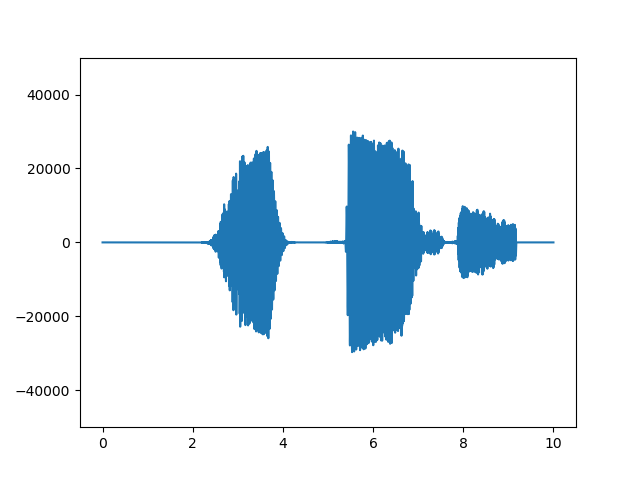

In [20]:
AfficheLectureEnregistrement("sound/custom 4b8.wav")

<IPython.core.display.Javascript object>


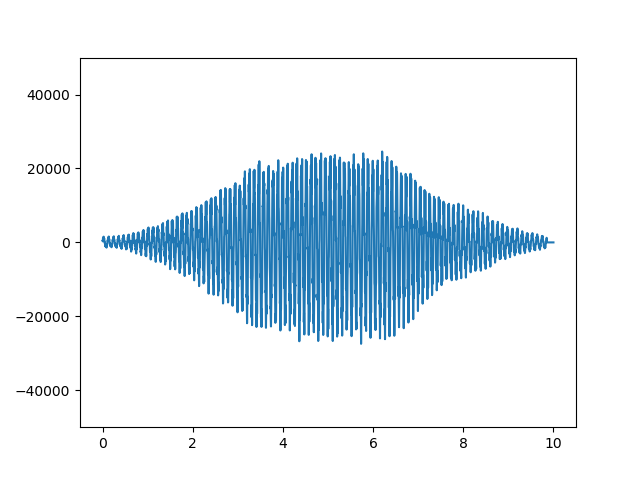

In [21]:
AfficheLectureEnregistrement("sound/c.wav")